## 패키지 설치 및 불러오기 

In [ ]:
!pip install --upgrade pip
!pip install konlpy  

!pip install nltk

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 19.4 MB 1.5 MB/s            
     |████████████████████████████████| 86 kB 5.2 MB/s             
     |████████████████████████████████| 448 kB 36.8 MB/s            
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import os
from tqdm import tqdm, tqdm_pandas

from konlpy.tag import Okt
from konlpy.tag import Mecab

import sklearn
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import log_loss, accuracy_score,f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from collections import Counter

from google.colab import drive

drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


## 데이터 불러오기

In [ ]:
file_path = '/content/drive/MyDrive/Graduate/ML_Programming/Data'

train=pd.read_csv(file_path+ '/' + 'train.csv')[:10000]
# 하드웨어 한계로 10000개만 추출 

In [ ]:
t = train.copy()

In [ ]:
t.head()

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드,label
0,0,2016,농업기초기반연구,농촌진흥청,신규,농산물안전성연구,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,○ 새로운 해충분류군의 동정기술 개발 및 유입확산 추적,(가) 외래 및 돌발해충의 발생조사 및 종 동정\n\n\n ○ 대상해충 : 최...,"○ 새로운 돌발 및 외래해충의 신속, 정확한 동정법 향상\n\n\n○ 돌발 및 외래...","뉴클레오티드 염기서열, 분자마커, 종 동정, 침샘, 전사체","nucleotide sequence, molecular marker, species...",24
1,1,2019,이공학학술연구기반구축(R&D),교육부,신규,지역대학우수과학자지원사업(1년~5년),대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,최종목표: TRAIL 감수성 표적 유전자를 발굴하고 내성제어 기전을 연구. 발굴된...,1차년도\n1) Microarray를 통한 선천적 TRAIL 내성 표적 후보 유전자...,"1) TRAIL 내성 특이적 표적분자를 발굴하고, 이를 이용한 TRAIL 효과 증진...","대장암,항암제 내성,세포사멸,유전자발굴","TRAIL,Colorectal cancer,TRAIL resistance,Apopt...",0
2,2,2016,중소기업기술혁신개발,중소기업청,신규,혁신기업기술개발,비목질계 셀룰로오스 식물자원을 활용한 기능성 부직포 및 고부가가치 뷰티케어 faci...,* 식물계자원 정련 및 최적 신서란 파이버 기초연구 개발\n\n\n* 소비자 및 바...,* 식물계자원 정련 및 최적 신서란 파이버 기초연구 개발\n\n\n- Tencel/...,* 국내 독자적인 비목질계 셀룰로오스 자원의 파이버 및 부직포 제조 등의 기술 확보...,"기능성 샐룰로오스 파이버,천연섬유,기능성 부직포,뷰티&amp;케어 제품,미용 솜","functional cellulose fiber,natural fiber,funct...",0
3,3,2018,창업성장기술개발(R&D),중소벤처기업부,신규,창업사업화연계과제,소화기 암 진단용 분자영상 형광프로브 개발,# 암특이적 바이오마커 발굴 및 바이오마커에 대한 프로브 개발\n\n\n1) 소화...,# 소화기 암 진단용 분자영상 형광프로브 개발\n\n\n- 국소 도포형 소화기 암 ...,# 암 진단기술의 차별성: 소화기 암 특이 프로브 개발\n\n\n- 최근 체외진단시...,"분자 진단,형광 조영제,프로브,항체,대장암","Molecular diagnosis,Fluorescence,probe,antibod...",0
4,4,2016,이공학개인기초연구지원,교육부,계속,기본연구지원,위암환자의 항암제반응예측을 위한 BRCA 발현검사,"수술이 불가능한 위암환자는 생존기간은 10개월 안팎에 지나지 않고, 항암화학요법에 ...",-In situ hybridization 검사의 정확성을 확인하기 위해 위암세포주 ...,-본 연구는 파라핀보관조직에서 in situ hybridization로 mRNA 및...,"BRCA,제자리부합법,조직미세배열,마이크로RNA,위암,항암제반응,젊은 연령/가족성 위암","BRCA,Insituhybridization,tissuemicroarray,micr...",0


In [ ]:
y = t['label']
X = t[t.columns.difference(['index','label'])]
# 학습에 사용할 데이터 지정 
# y는 Label만 지정 
# X는 index와 label을 제외한 text로 구성된 데이터 모두 출력 

In [ ]:
print(X.columns)
print(y)

Index(['계속과제여부', '과제명', '내역사업명', '사업_부처명', '사업명', '요약문_기대효과', '요약문_연구내용',
       '요약문_연구목표', '요약문_영문키워드', '요약문_한글키워드', '제출년도'],
      dtype='object')
0       24
1        0
2        0
3        0
4        0
        ..
9995     0
9996    27
9997     0
9998     0
9999     0
Name: label, Length: 10000, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=410)
# sklearn패키지를 활용하여 학습 및 테스트 데이터 분리 

In [ ]:
print(len(y_test.unique()))
print(len(y_train.unique()))
# 동일한 label 개수가 출력 

45
45


dict_keys([0, 23, 36, 5, 18, 27, 16, 19, 13, 1, 24, 29, 20, 31, 30, 14, 45, 44, 39, 21, 26, 43, 8, 40, 34, 6, 22, 33, 10, 7, 15, 2, 35, 38, 11, 25, 28, 12, 3, 32, 37, 9, 17, 4, 41])
dict_values([5695, 82, 47, 68, 69, 26, 19, 211, 23, 59, 144, 40, 43, 36, 11, 59, 39, 4, 6, 22, 13, 17, 10, 17, 22, 5, 9, 16, 36, 4, 11, 11, 13, 12, 5, 24, 19, 9, 4, 10, 13, 8, 4, 2, 3])


<BarContainer object of 45 artists>

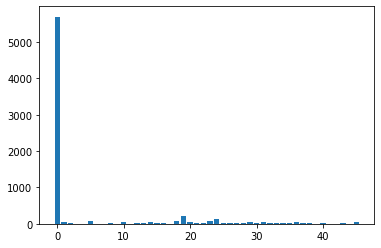

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

count = Counter(y_train)
print(count.keys())
print(count.values())
plt.bar(count.keys(), count.values())

In [ ]:
y_train[0].shape

TensorShape([46])

dict_keys([5, 0, 19, 16, 24, 23, 28, 1, 8, 20, 14, 29, 43, 18, 13, 31, 33, 27, 10, 34, 15, 45, 30, 25, 35, 36, 6, 32, 3, 17, 39, 22, 40, 26, 12, 21, 2, 38, 11, 7, 4, 9, 42, 37, 41])
dict_values([23, 2442, 84, 10, 62, 33, 11, 21, 8, 12, 29, 18, 5, 21, 11, 15, 10, 23, 14, 10, 6, 18, 5, 12, 7, 28, 2, 5, 3, 3, 5, 3, 8, 3, 5, 5, 3, 6, 2, 1, 3, 1, 1, 2, 1])


<BarContainer object of 45 artists>

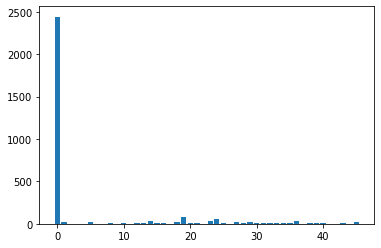

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

count = Counter(y_test)
print(count.keys())
print(count.values())
plt.bar(count.keys(), count.values())

## 텍스트 전처리

In [ ]:
X_train.fillna('NoContent', inplace=True)
X_test.fillna('NoContent', inplace=True)
# 결측값을 Nocontent로 변환 

In [ ]:
okt = Okt()
def trans_token(text):

  text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z\- ]"," ", text)
  # 한글과 영어를 제외한 나머지 제외 
  text = text.lower()
  # 대문자로 구성된 텍스트는 소문자로 변환 
  if len(text) == 0:
    return ['NoContent']
    # 텍스트 길이가 0이면 특정 키워드 출력 
  return okt.pos(text)

In [ ]:
# 키워드는 대부분 품사가 명사임
tokens = okt.pos(X_train['과제명'].loc[0])
only_noun = [ x[0] for x in tokens if x[1] == 'Noun']
print(train['과제명'].loc[0])
print(only_noun)

유전정보를 활용한 새로운 해충 분류군 동정기술 개발
['유전', '정보', '활용', '해충', '분류군', '동정', '기술', '개발']


In [ ]:
def united_contents(text):
  text = re.sub('\(R&D\)','',text)
  # R&D라는 내용 제거 
  text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z ]','',text)
  # 한글과 영어를 제외한 나머지 제거 
  return [text]

X_train['united_내역사업명'] = X_train['내역사업명'].apply(united_contents)
X_test['united_내역사업명'] = X_test['내역사업명'].apply(united_contents)

In [ ]:
X_train['united_내역사업명']

6109                           [중개연구]
6761                     [대구튜닝전문지원센터]
2884                         [첫걸음 협력]
7867                         [기본연구년년]
4333                  [주요사업비분석연구지원사업]
                    ...              
4236                     [산학연RBD협력사업]
2464                         [지능형소비자]
5413                     [국토공간정보연구사업]
7482                     [구매조건부신제품개발]
174     [스마트팜맵 이용 토양검정 및 농업환경자원 변동평가]
Name: united_내역사업명, Length: 7000, dtype: object

In [ ]:
tqdm_pandas(tqdm())

X_train['token_내역사업명'] = X_train['united_내역사업명'].progress_apply(trans_token)
X_train['token_과제명'] = X_train['과제명'].progress_apply(trans_token)
X_train['token_요약문_한글키워드'] = X_train['요약문_한글키워드'].progress_apply(trans_token)
X_train['token_요약문_연구목표'] = X_train['요약문_연구목표'].progress_apply(trans_token)

X_test['token_내역사업명'] = X_test['united_내역사업명'].progress_apply(trans_token)
X_test['token_과제명'] = X_test['과제명'].progress_apply(trans_token)
X_test['token_요약문_한글키워드'] = X_test['요약문_한글키워드'].progress_apply(trans_token)
X_test['token_요약문_연구목표'] = X_test['요약문_연구목표'].progress_apply(trans_token)
# 문장으로 구성된 데이터를 okt형태소 분석기를 활용하여 토큰으로 바꿔줌 
# 시간이 오래걸림

0it [00:00, ?it/s]
1it [00:00, 185.24it/s]


TypeError: ignored

In [ ]:
train = X_train[['token_내역사업명', 'token_과제명', 'token_요약문_한글키워드', 'token_요약문_연구목표']]
test = X_test[['token_내역사업명', 'token_과제명', 'token_요약문_한글키워드', 'token_요약문_연구목표']]
# 학습에 사용할 데이터 지정 

train.to_csv('/content/drive/MyDrive/Graduate/ML_Programming/Data/extract7000_okt_train.csv', index = False)
test.to_csv('/content/drive/MyDrive/Graduate/ML_Programming/Data/extract3000_okt_test.csv', index = False)
# 데이터 저장 

In [ ]:
train
# 토큰과 해당 품사로 구성 

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Graduate/ML_Programming/Data/extract7000_okt_train.csv')
test=pd.read_csv('/content/drive/MyDrive/Graduate/ML_Programming/Data/extract3000_okt_test.csv')

In [ ]:
train

,token_내역사업명,token_과제명,token_요약문_한글키워드,token_요약문_연구목표
0,"[('중개', 'Noun'), ('연구', 'Noun')]","[('rhpth', 'Alpha'), ('-', 'Punctuation'), ('를...","[('비', 'Noun'), ('스포', 'Noun'), ('스포', 'Noun')...","[('비', 'Noun'), ('스포', 'Noun'), ('스포', 'Noun')..."
1,"[('대', 'Modifier'), ('구', 'Modifier'), ('튜닝', ...","[('대', 'Modifier'), ('구', 'Modifier'), ('튜닝', ...","[('튜닝', 'Noun'), ('카바', 'Noun'), ('타', 'Noun')...","[('대구시', 'Noun'), ('에', 'Josa'), ('튜닝', 'Noun'..."
2,"[('첫걸음', 'Noun'), ('협력', 'Noun')]","[('드론', 'Noun'), ('영상', 'Noun'), ('과', 'Josa')...","[('융합', 'Noun'), ('레이저', 'Noun'), ('스캐너', 'Nou...","[('대형', 'Noun'), ('레이저', 'Noun'), ('스캐너', 'Nou..."
3,"[('기', 'Modifier'), ('본', 'Modifier'), ('연', '...","[('고', 'Modifier'), ('자기장', 'Noun'), ('하', 'No...","[('화합물', 'Noun'), ('반도체', 'Noun'), ('광', 'Noun...","[('기초', 'Noun'), ('연구', 'Noun'), ('로서', 'Noun'..."
4,"[('주요', 'Modifier'), ('사업', 'Noun'), ('비분', 'N...","[('전주', 'Noun'), ('센터', 'Noun'), ('운영', 'Noun')]","[('기기', 'Noun'), ('분석', 'Noun'), ('지원', 'Noun'...","[('-', 'Punctuation'), ('첨단', 'Noun'), ('연', '..."
...,...,...,...,...
6995,"[('산학', 'Noun'), ('연', 'Noun'), ('rbd', 'Alpha...","[('multi', 'Alpha'), ('color', 'Alpha'), ('수지'...","[('고', 'Modifier'), ('감성', 'Noun'), ('윈도우', 'N...","[('멀티', 'Noun'), ('컬러', 'Noun'), ('구현', 'Noun'..."
6996,"[('지능', 'Noun'), ('형', 'Suffix'), ('소비자', 'Nou...","[('커뮤니티', 'Noun'), ('에너지', 'Noun'), ('공급', 'No...","[('구역', 'Noun'), ('전기', 'Noun'), ('사업', 'Noun'...","[('ㅇ', 'KoreanParticle'), ('ces', 'Alpha'), ('..."
6997,"[('국토', 'Noun'), ('공간', 'Noun'), ('정보', 'Noun'...","[('공간', 'Noun'), ('정보산업', 'Noun'), ('활성화', 'No...","[('오픈소스', 'Noun'), ('공간', 'Noun'), ('정보', 'Nou...","[('-', 'Punctuation'), ('오픈', 'Noun'), ('소스', ..."
6998,"[('구매', 'Noun'), ('조건', 'Noun'), ('부신', 'Noun'...","[('블록', 'Noun'), ('체인', 'Noun'), ('플랫폼', 'Noun...","[('블록', 'Noun'), ('체인', 'Noun'), ('모바일', 'Noun...","[('o', 'Alpha'), ('블록', 'Noun'), ('체인', 'Noun'..."


In [ ]:
# csv에는 리스트로 저장했던 것들이 문자열로 바뀌어있었으므로 문자열을 다시 리스트 형태로 변환
def trans_to_list(text):
  text = re.sub("[\[\]\' ]", "", str(text))
  text =  text.split(',')
  if text == ['']:
    text = ['']
  return text

train['fixed_과제명'] = train['token_과제명'].apply(trans_to_list)
train['fixed_내역사업명'] = train['token_내역사업명'].apply(trans_to_list)
train['fixed_요약문_한글키워드'] = train['token_요약문_한글키워드'].apply(trans_to_list)
train['fixed_요약문_연구목표'] = train['token_요약문_연구목표'].apply(trans_to_list)

test['fixed_과제명'] = test['token_과제명'].apply(trans_to_list)
test['fixed_내역사업명'] = test['token_내역사업명'].apply(trans_to_list)
test['fixed_요약문_한글키워드'] = test['token_요약문_한글키워드'].apply(trans_to_list)
test['fixed_요약문_연구목표'] = test['token_요약문_연구목표'].apply(trans_to_list)

In [ ]:
train['vocab'] = train['fixed_내역사업명'] + train['fixed_과제명']  + train['fixed_요약문_한글키워드'] + train['fixed_요약문_연구목표']
# vocab에 데이터를 전부 합침 

In [ ]:
tokenizer=Tokenizer(oov_token = 'OOV')
# OOV : out of vocab 
# 사전에 없는 단어를 의미 

tokenizer.fit_on_texts(list(train['vocab']))
word_vocab = tokenizer.word_index
# vocab에 있는 토큰을 고유한 형태의 index로 변환 

vocab_size = len(word_vocab)+2

In [ ]:
threshold = 10 
# 최소빈도 
total_cnt = len(tokenizer.word_index) 
# 단어의 수
rare_cnt = 0 
# 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 
# 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 
# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받으며 tokenizer.word_counts는 각 토큰의 빈도를 나타냄 
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    # 전체 단어 빈도 합 

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        # 기준 변수인 threshold보다 빈도가 작으면 카운트 1 
        rare_freq = rare_freq + value
        # 기준 변수 threshold보다 빈도가 작은 토큰의 총 빈도 수 
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

print('예상 단어집합 크기 :',total_cnt - rare_cnt)
words_num = total_cnt - rare_cnt

단어 집합(vocabulary)의 크기 : 31987
등장 빈도가 9번 이하인 희귀 단어의 수: 24979
단어 집합에서 희귀 단어의 비율: 78.09109950917559
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.160004209583918
예상 단어집합 크기 : 7008


In [ ]:
# tokenizer=Tokenizer()
tokenizer=Tokenizer(num_words=words_num,oov_token = 'OOV')

tokenizer.fit_on_texts(list(train['vocab']))
word_vocab = tokenizer.word_index

vocab_size = len(word_vocab)+2

In [ ]:
train['input_0'] = train['fixed_내역사업명'] + train['fixed_과제명'] + train['fixed_요약문_한글키워드']
train['input_1'] = train['fixed_요약문_연구목표']

In [ ]:
test['input_0'] = test['fixed_내역사업명'] + test['fixed_과제명'] + test['fixed_요약문_한글키워드']
test['input_1'] = test['fixed_요약문_연구목표']

문장 길이 제 1 사분위: 50.0
문장 길이 제 3 사분위: 74.0
문장 길이 98%: 104.0


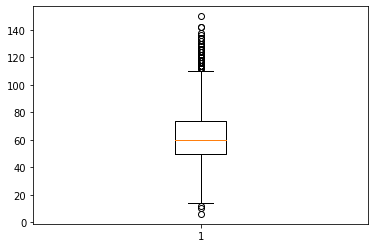

In [ ]:
import matplotlib.pyplot as plt

train_length = train['input_0'].apply(len)
plt.boxplot(train_length);
print('문장 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

number = 98
print('문장 길이 {}%: {}'.format(number,np.percentile(train_length, number)))

인풋 길이 제 1 사분위: 96.0
인풋 길이 제 3 사분위: 302.0
인풋 길이 98%: 724.039999999999


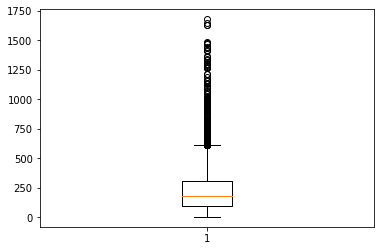

In [ ]:
import matplotlib.pyplot as plt

train_length = train['input_1'].apply(len)
plt.boxplot(train_length);
print('인풋 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('인풋 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

number = 98
print('인풋 길이 {}%: {}'.format(number,np.percentile(train_length, number)))

In [ ]:
max_len = [74, 302]
# 제 3사분위의 문장길이를 max_len으로 지정 


train_encoded_0 = tokenizer.texts_to_sequences(list(train['input_0']))
train_input_0 = pad_sequences(train_encoded_0, maxlen=max_len[0], padding='post')
# 텍스트 데이터를 숫자로 바꿔주고 고정된 길이에 맞게 padding

train_encoded_1 = tokenizer.texts_to_sequences(list(train['input_1']))
train_input_1 = pad_sequences(train_encoded_1, maxlen=max_len[1], padding='post')
# 텍스트 데이터를 숫자로 바꿔주고 고정된 길이에 맞게 padding

train_input_0 = tf.convert_to_tensor(train_input_0, dtype=tf.float32)
train_input_1 = tf.convert_to_tensor(train_input_1, dtype=tf.float32)
# 숫자로 변경된 데이터를 tensor로 변환 

train_input = []
train_input.append(train_input_0)
train_input.append(train_input_1)
# 요약문 텍스트와 나머지 텍스트를 분리하여 개별 학습 진행 

In [ ]:
test_encoded_0 = tokenizer.texts_to_sequences(list(test['input_0']))
test_input_0 = pad_sequences(test_encoded_0, maxlen=max_len[0], padding='post')
# 텍스트 데이터를 숫자로 바꿔주고 고정된 길이에 맞게 padding

test_encoded_1 = tokenizer.texts_to_sequences(list(test['input_1']))
test_input_1 = pad_sequences(test_encoded_1, maxlen=max_len[1], padding='post')
# 텍스트 데이터를 숫자로 바꿔주고 고정된 길이에 맞게 padding

test_input_0 = tf.convert_to_tensor(test_input_0, dtype=tf.float32)
test_input_1 = tf.convert_to_tensor(test_input_1, dtype=tf.float32)
# 숫자로 변경된 데이터를 tensor로 변환 

test_input = []
test_input.append(test_input_0)
test_input.append(test_input_1)
# 요약문 텍스트와 나머지 텍스트를 분리하여 개별 학습 진행 

In [ ]:
def trans_label(number):
    vector =  np.array([0] * 46)
    vector[number] = 1
    return vector
    # label을 vector화 

# label이 46개이므로 각각 특정 라벨을 인식하기 위해서 원핫인코딩 수행 

y_train = y_train.apply(trans_label)
y_test = y_test.apply(trans_label)

y_train = tf.convert_to_tensor(list(y_train), dtype = tf.float32)
y_test = tf.convert_to_tensor(list(y_test), dtype = tf.float32)
# 학습시키기 위해 tensor로 변환 

In [ ]:
print(y_train);
print(y_test);
# 변환이 잘된것을 확인 

[0 0 0 ... 0 0 0]
4403     5
4831     0
7441     0
121      0
4335    19
        ..
8032     0
2424     0
3519    31
7271     0
223      0
Name: label, Length: 3000, dtype: int64


In [ ]:
train_input_0

<tf.Tensor: shape=(7000, 74), dtype=float32, numpy=
array([[1.500e+01, 1.400e+01, 1.300e+01, ..., 7.000e+00, 7.460e+02,
        2.000e+00],
       [2.510e+02, 7.000e+00, 8.400e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.606e+03, 2.000e+00, 2.130e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.513e+03, 2.000e+00, 2.770e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.145e+03, 2.000e+00, 1.800e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.620e+02, 2.000e+00, 1.438e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00]], dtype=float32)>

In [ ]:
print(y_train)
print(train_input_0)

tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], shape=(7000, 46), dtype=float32)
tf.Tensor(
[[1.500e+01 1.400e+01 1.300e+01 ... 7.000e+00 7.460e+02 2.000e+00]
 [2.510e+02 7.000e+00 8.400e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.606e+03 2.000e+00 2.130e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [2.513e+03 2.000e+00 2.770e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.145e+03 2.000e+00 1.800e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.620e+02 2.000e+00 1.438e+03 ... 0.000e+00 0.000e+00 0.000e+00]], shape=(7000, 74), dtype=float32)


In [ ]:
print(train_input_1)

tf.Tensor(
[[1.590e+02 2.000e+00 3.064e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 2.000e+00 1.600e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.215e+03 2.000e+00 5.460e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [1.500e+01 1.400e+01 1.888e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.650e+02 4.000e+00 1.052e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 [5.395e+03 2.000e+00 9.100e+01 ... 0.000e+00 0.000e+00 0.000e+00]], shape=(7000, 302), dtype=float32)


In [ ]:
len(y_train)

7000

## 학습 모델 생성

In [ ]:
embedding_dim = [512, 512]
# 512차원으로 임베딩 

def convolutional_model(embedding_dim = embedding_dim, max_len = max_len, num_labels = 46):
    
    train_input_0 = tf.keras.Input(shape=(max_len[0],))
    train_input_1 = tf.keras.Input(shape=(max_len[1],))

    # 요약문 제외 나머지 학습 
    x0 = tf.keras.layers.Embedding(vocab_size, embedding_dim[0], input_length=max_len[0], mask_zero=True)(train_input_0)
    x0 = tf.keras.layers.Dropout(0.2)(x0)

    x0 = tf.keras.layers.Conv1D(embedding_dim[0], kernel_size=3, padding='valid', activation=None)(x0)
    x0 = tf.keras.layers.BatchNormalization()(x0)
    x0 = tf.keras.layers.Activation('relu')(x0)
    x0 = tf.keras.layers.Dropout(0.2)(x0)
    x0 = tf.keras.layers.GlobalMaxPooling1D()(x0)

    x0 = tf.keras.layers.Dense(128, activation=None)(x0)
    # x0 = tf.keras.layers.BatchNormalization()(x0)
    # x0 = tf.keras.layers.Activation('relu')(x0)
    # x0 = tf.keras.layers.Dropout(0.2)(x0)


    # 요약문 학습 
    x1 = tf.keras.layers.Embedding(vocab_size, embedding_dim[1], input_length=max_len[1], mask_zero=True)(train_input_1)
    x1 = tf.keras.layers.Dropout(0.2)(x1)
    
    x1 = tf.keras.layers.Conv1D(embedding_dim[1], kernel_size=3, padding='valid', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Dropout(0.2)(x1)
    x1 = tf.keras.layers.GlobalMaxPooling1D()(x1)

    x1 = tf.keras.layers.Dense(128, activation=None)(x1)
    # x1 = tf.keras.layers.BatchNormalization()(x1)
    # x1 = tf.keras.layers.Activation('relu')(x1)
    # x1 = tf.keras.layers.Dropout(0.2)(x1)


    fc = tf.keras.layers.Concatenate()([x0,x1])

    fc = tf.keras.layers.Dense(64, activation=None)(fc)
    fc = tf.keras.layers.BatchNormalization()(fc)
    fc = tf.keras.layers.Activation('relu')(fc)
    fc = tf.keras.layers.Dropout(0.2)(fc)

    labels = tf.keras.layers.Dense(num_labels, activation = 'softmax')(fc)
    # 마지막 activation function 지정 
    
    model = tf.keras.Model([train_input_0,train_input_1], labels)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer = optimizer, loss = 'CategoricalCrossentropy', metrics = ['accuracy'])
    # loss와 optimize function, metric 지정 
    
    return model

In [ ]:
from PIL import Image

model = convolutional_model()
tf.keras.utils.plot_model(model, dpi = 500, show_shapes=True)
img = Image.open('model.png')
img

## 모델 학습 

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

model = convolutional_model()


num_epochs = 15

history = model.fit(train_input, y_train, epochs=num_epochs, batch_size=32, verbose=1, validation_split=0.2, callbacks=[es, mc])

Epoch 1/15
175/175 [==============================] - ETA: 0s - loss: 1.6938 - accuracy: 0.7021
Epoch 00001: val_accuracy improved from -inf to 0.80929, saving model to best_model.h5
175/175 [==============================] - 21s 113ms/step - loss: 1.6938 - accuracy: 0.7021 - val_loss: 1.1822 - val_accuracy: 0.8093
Epoch 2/15
175/175 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.8486
Epoch 00002: val_accuracy did not improve from 0.80929
175/175 [==============================] - 16s 92ms/step - loss: 0.6927 - accuracy: 0.8486 - val_loss: 1.3351 - val_accuracy: 0.8093
Epoch 3/15
175/175 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8971
Epoch 00003: val_accuracy improved from 0.80929 to 0.81214, saving model to best_model.h5
175/175 [==============================] - 17s 97ms/step - loss: 0.4180 - accuracy: 0.8971 - val_loss: 0.9449 - val_accuracy: 0.8121
Epoch 4/15
175/175 [==============================] - ETA: 0s - loss: 0.2440 - a

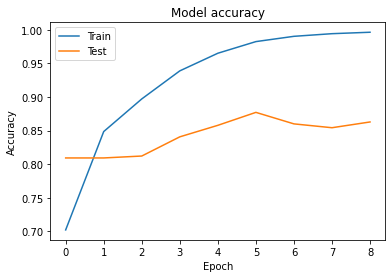

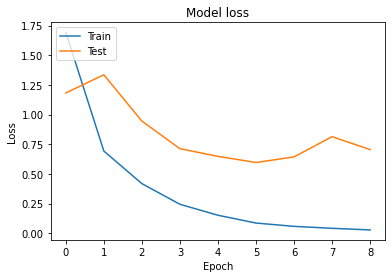

In [ ]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 모델 검증

In [ ]:
pred=model.predict(test_input)

In [ ]:
results = model.evaluate(test_input, y_test)
print(results)

94/94 [==============================] - 2s 17ms/step - loss: 0.7610 - accuracy: 0.8550
[0.7609765529632568, 0.8550000190734863]
